# Multimodal ML – Housing Price Prediction Using Images + Tabular Data:


---


---

## Objective:
* Predict house prices using images and tabular data.

## Methodology:
**1. Image Feature Extraction:**
  * Used a frozen, pre-trained VGG16 CNN to extract high-level visual features from house images.

**2. Feature Fusion:**
  * Combined the extracted image features with preprocessed tabular data (e.g., bedrooms, area) using a concatenation layer.

**3. Model Training:**
  * Trained a single, unified neural network on this combined data to learn price predictions.

**4. Evaluation:**
  * Assessed the model's performance on a test set using standard regression metrics.

## Key Results:

* The model successfully learned from both data modalities.
* Achieved a final Mean Absolute Error MAE of 267,571 on unseen test data.
* Achieved a Root Mean Squared Error RMSE of $388,832.
* Training and validation plots showed successful learning without signs of overfitting.



---



---



### Setup And Load Datasets:


---


---
This section imports necessary libraries and sets up the Google Colab environment. It defines file paths, uses a shell command to unzip the image archive, and loads the tabular data into a pandas DataFrame. This ensures all data is accessible and verified before proceeding.

---


---





In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Concatenate
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# First, install the p7zip package if you haven't already in this session.
print("Installing p7zip-full...")
!apt-get install p7zip-full -y -q
print("p7zip installed.")

Installing p7zip-full...
Reading package lists...
Building dependency tree...
Reading state information...
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
p7zip installed.


In [4]:
# Next, extract the .7z file.
print("Extracting socal_pics.7z...")
!7z x /content/socal_pics.7z -o/content/
print("Extraction complete.")


Extracting socal_pics.7z...

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 41993582 bytes (41 MiB)

Extracting archive: /content/socal_pics.7z
--
Path = /content/socal_pics.7z
Type = 7z
Physical Size = 41993582
Headers Size = 13208
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      6% 1       10% 173 - socal_pics/1152.jpg                               18% 343 - socal_pics/1305.jpg                               23% 418 - socal_pics/1373.jpg                               31% 518 - socal_pics/1463.jpg

In [13]:
# Define file paths
TABULAR_DATA_PATH = '/content/socal2.csv'
IMAGES_PATH = '/content/socal_pics'

In [14]:
# Define image dimensions for the CNN model
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3

In [15]:
# Load the tabular data
try:
    df = pd.read_csv(TABULAR_DATA_PATH)
    print("Tabular Data loaded successfully.")
    print(f"Loaded {len(df)} rows from the tabular dataset.")
except FileNotFoundError:
    print(f"Error: Tabular data not found at {TABULAR_DATA_PATH}")
    exit()

print("\nTabular Data Head:")
print(df.head())
print(f"\nTotal rows in dataset: {len(df)}")

Tabular Data loaded successfully.
Loaded 2000 rows from the tabular dataset.

Tabular Data Head:
   image_id                 street             citi  n_citi  bed  bath  sqft  \
0         0  1317 Van Buren Avenue  Salton City, CA     317    3   2.0  1560   
1         1         124 C Street W      Brawley, CA      48    3   2.0   713   
2         2        2304 Clark Road     Imperial, CA     152    3   1.0   800   
3         3     755 Brawley Avenue      Brawley, CA      48    3   1.0  1082   
4         4  2207 R Carrillo Court     Calexico, CA      55    4   3.0  2547   

    price  
0  201900  
1  228500  
2  273950  
3  350000  
4  385100  

Total rows in dataset: 2000


### Image Preprocessing & Loading:


---

---

A function is defined to prepare images for the CNN. This involves resizing and normalizing each image, and handling any missing files. All 2000 images are loaded into a NumPy array, ready for processing.


---



---



In [16]:
def load_and_preprocess_image(image_id):

    try:
        image_path = os.path.join(IMAGES_PATH, f'{image_id}.jpg')
        if not os.path.exists(image_path):
            return None

        img = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        img_array = np.array(img, dtype='float32')

        if img_array.ndim == 2:
            img_array = np.stack([img_array] * 3, axis=-1)
        elif img_array.shape[2] == 4:
            img_array = img_array[:, :, :3]

        img_array /= 255.0
        return img_array
    except Exception as e:
        print(f"Error processing image {image_id}: {e}")
        return None

In [17]:
# Filter out rows where the image file is missing or corrupted
df['image_file_path'] = df['image_id'].apply(lambda x: os.path.join(IMAGES_PATH, f'{x}.jpg'))
valid_indices = df['image_file_path'].apply(os.path.exists)
df = df[valid_indices].reset_index(drop=True)
print(f"\nFiltered dataset to {len(df)} rows with valid images.")


Filtered dataset to 2000 rows with valid images.


In [19]:
# Load and preprocess all valid images
print("\nLoading and preprocessing images...")
images = []
for image_id in df['image_id']:
    img_array = load_and_preprocess_image(image_id)
    if img_array is not None:
        images.append(img_array)
    else:
        df = df[df['image_id'] != image_id].reset_index(drop=True)

images = np.array(images)
print(f"Successfully loaded and preprocessed {len(images)} images.")


Loading and preprocessing images...
Successfully loaded and preprocessed 2000 images.


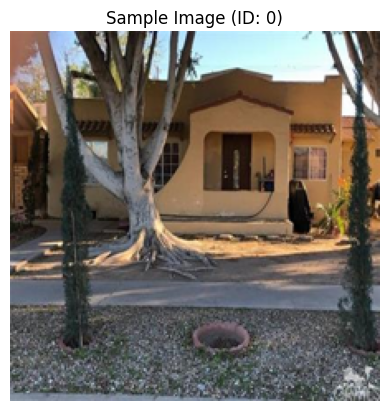

In [22]:
# Sanity check: Plot a sample image
plt.imshow(images[1])
plt.title(f"Sample Image (ID: {df.iloc[0]['image_id']})")
plt.axis('off')
plt.show()

### Tabular Data Preprocessing:


---



---


This part prepares the structured data. It separates features from the target variable and uses a ColumnTransformer to standardize numerical data and one-hot encode categorical data. This ensures the tabular data is correctly formatted and scaled.


---



---



In [23]:
# Separate features and target variable
y = df['price'].values
X_tabular = df.drop(columns=['image_id', 'price', 'image_file_path'])

In [24]:
# Identify categorical and numerical columns for preprocessing
numerical_cols = X_tabular.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_tabular.select_dtypes(include='object').columns.tolist()

In [25]:
# Create a preprocessing pipeline for tabular data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

In [27]:
print("\nPreprocessed Tabular data shape:", X_tabular_processed.shape)


Preprocessed Tabular data shape: (2000, 1854)


### Splitting Data and CNN Feature Extraction:


---



---


The dataset is split into training and test sets. A pre-trained VGG16 CNN is used as a feature extractor by freezing its layers. The output is a flattened vector of image features, prepared for fusion.


---



---



In [28]:
# Split the dataset into training and testing sets
X_tabular_train, X_tabular_test, y_train, y_test, images_train, images_test = train_test_split(
    X_tabular_processed, y, images, test_size=0.2, random_state=42
)

In [29]:
print(f"\nTraining set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")


Training set size: 1600
Test set size: 400


In [30]:
# Load a pre-trained VGG16 model as a feature extractor
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [31]:
# Freeze the convolutional layers to prevent them from being updated
for layer in base_model.layers:
    layer.trainable = False

In [32]:
# Create the CNN feature extractor model
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.models import Model

cnn_input = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), name='cnn_input')
cnn_output = base_model(cnn_input)
cnn_output = Flatten()(cnn_output)
cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

print("\nCNN Feature Extractor Model Summary:")
cnn_model.summary()


CNN Feature Extractor Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Combining Image + Tabular Features:


---



---


This section builds the core of the multimodal model. It defines two input branches, processes the features from each modality, and then fuses them using a Concatenate layer. This combined vector forms the input for the final regression head.


---



---



In [33]:
# Define the two input branches for the multimodal model
from tensorflow.keras.layers import Concatenate

tabular_input = Input(shape=(X_tabular_train.shape[1],), name='tabular_input')
image_input = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), name='image_input')

In [34]:
# Process the image input through the pre-trained CNN
image_features = cnn_model(image_input)

In [35]:
# Define the dense layers for the tabular data
tabular_features = Dense(64, activation='relu')(tabular_input)
tabular_features = Dense(32, activation='relu')(tabular_features)

In [36]:
# Concatenate the features from both modalities
concatenated_features = Concatenate()([image_features, tabular_features])

In [37]:
# Create the final regression head
combined_features = Dense(128, activation='relu')(concatenated_features)
combined_features = Dense(64, activation='relu')(combined_features)
output = Dense(1, activation='linear', name='price_output')(combined_features)

In [38]:
# Define the complete multimodal model
multimodal_model = Model(inputs=[image_input, tabular_input], outputs=output)

In [39]:
print("\nMultimodal Model Architecture Summary:")
multimodal_model.summary()


Multimodal Model Architecture Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 1854)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    118,720 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 25088)     │ 14,714,688 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 25120)     │          0 │ functional[0][0], │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,215,488 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price_output        │ (None, 1)         │         65 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,059,297 (68.89 MB)

 Trainable params: 3,344,609 (12.76 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Training Regression Model:


---



---


The model is compiled with an Adam optimizer and mean_squared_error loss. It is then trained for 10 epochs on the combined data, with a validation split. Training plots visualize the model's learning progress, showing decreasing loss and MAE


---



In [42]:
# Compile the model
multimodal_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)
print("\nStarting model training...")

history = multimodal_model.fit(
    {'image_input': images_train, 'tabular_input': X_tabular_train},
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)
print("Model training complete.")



Starting model training...
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - loss: 452517789696.0000 - mae: 536726.2500 - val_loss: 470031892480.0000 - val_mae: 547699.8125
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - loss: 447340707840.0000 - mae: 531943.3750 - val_loss: 454659145728.0000 - val_mae: 533518.6875
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - loss: 426785996800.0000 - mae: 512431.1250 - val_loss: 412519071744.0000 - val_mae: 492660.2500
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - loss: 376681529344.0000 - mae: 461463.9375 - val_loss: 333120077824.0000 - val_mae: 405157.0625
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - loss: 290461188096.0000 - mae: 358474.1875 - val_loss: 232409169920.0000 - val_mae: 271836.0625
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - loss: 196353802240.0000 - mae: 242305.8438 - val_loss: 168900739072.0000 - val_mae: 238468.9688
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 14952764

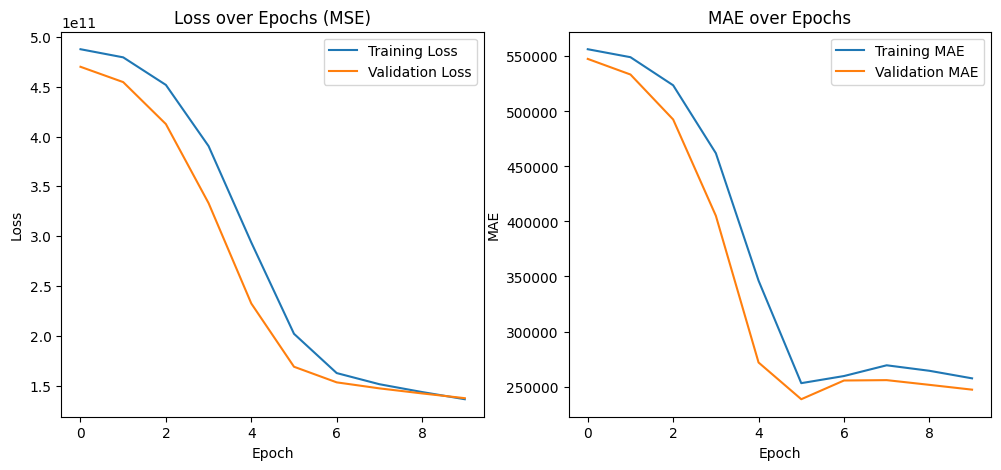

In [43]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

### Evaluation using MAE and RMSE:


---



---


The final step evaluates the model on the test set. It calculates and prints the MAE and RMSE metrics, providing an average error in dollars. A scatter plot of actual vs. predicted prices offers a visual summary of the model's final performance.


---



In [44]:
print("\nEvaluating the model on the test set...")

predictions = multimodal_model.predict({'image_input': images_test, 'tabular_input': X_tabular_test})


Evaluating the model on the test set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 776ms/step


In [45]:
# Calculate the evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"\nFinal Evaluation on Test Data:")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")


Final Evaluation on Test Data:
Mean Absolute Error (MAE): $267,571.00
Root Mean Squared Error (RMSE): $388,832.72


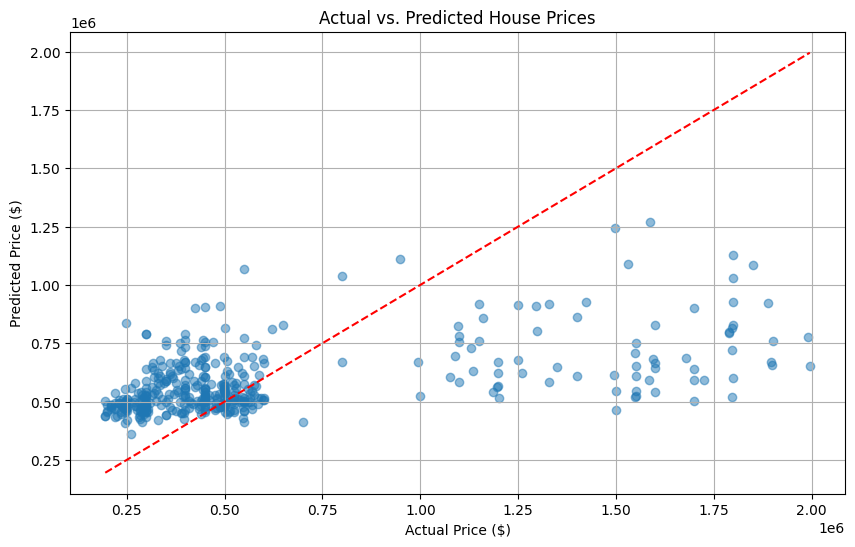

In [46]:
# Visualize predictions vs. actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs. Predicted House Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()